In [3]:
%matplotlib notebook
import torch
from torch.autograd import Variable
import numpy as np
import torch.nn as nn
import torchaudio
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
from downModel import AutoEncoder
from torch.utils.data import DataLoader
from utils import load_dataset,myspec
from os import listdir
import math
from IPython.display import Audio

In [4]:
dataloader=load_dataset(samples=20)

trainset=DataLoader(dataloader, batch_size=62, shuffle=False,drop_last=True, num_workers=1)

def latent_loss(mean,sd,mul):
    mean2=mean*mean
    sd2=sd*sd
    loss=mul*torch.mean(mean2+sd2-torch.log(sd2)-1)
    fll=float(torch.mean(mean2+sd2-torch.log(sd2)-1))
    return loss,fll

def upsample(x,rate=2):
    return np.interp(np.linspace(0,len(x),rate*len(x)),np.linspace(0,len(x),len(x)),x)
def downsample(x,rate=2):
    return x[::rate]


Current Samples:  12400


In [5]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        
        
        self.encoder=nn.ModuleList([
            nn.Conv1d(1,8,8,4,0,dilation=2), nn.ReLU(),
            nn.Conv1d(8,64,8,4,0,dilation=2), nn.ReLU(),
            nn.Conv1d(64,128,8,4,0,dilation=2), nn.ReLU(),
            nn.Conv1d(128,256,4,2,0,dilation=1), nn.ReLU(),
            nn.Conv1d(256,256,4,2,0,dilation=1), nn.ReLU(),  
        ])
        self.meanL=nn.Sequential(
            nn.Linear(256,256),nn.ReLU(),
            nn.Linear(256,256),nn.ReLU(),
            nn.Linear(256,128),nn.ReLU(),
            nn.Linear(128,128),nn.ReLU(),
            nn.Linear(128,128),nn.ReLU(),
            nn.Linear(128,127),nn.ReLU()
        )
        self.sigmaL=nn.Sequential(
            nn.Linear(256,256),nn.ReLU(),
            nn.Linear(256,256),nn.ReLU(),
            nn.Linear(256,128),nn.ReLU(),
            nn.Linear(128,128),nn.ReLU(),
            nn.Linear(128,128),nn.ReLU(),
            nn.Linear(128,127),nn.ReLU()
        )
        

    def sample_latent(self,x,cl):
        mean=self.meanL(x)
        sigma=self.sigmaL(x)
        sigma=torch.sqrt(torch.exp(sigma))
        self.mean=mean
        self.sigma=sigma
        eps = torch.distributions.normal.Normal(0, 1).sample(sample_shape=sigma.size())
        z=mean+sigma*Variable(eps,requires_grad=False).cuda()
        z=torch.cat((z,cl),dim=1)
        return z
    
    def forward(self,x):
        cl=x[0:x.shape[0],0,-1].view(x.shape[0],1)
        x=x[0:x.shape[0],0,0:1024].view(x.shape[0],1,1024)

        for conv in self.encoder:
            x=conv(x)

        x=x.view(x.shape[0],256)
        z=self.sample_latent(x,cl)
        return z
enc=Encoder().cuda()
print(enc)

Encoder(
  (encoder): ModuleList(
    (0): Conv1d(1, 8, kernel_size=(8,), stride=(4,), dilation=(2,))
    (1): ReLU()
    (2): Conv1d(8, 64, kernel_size=(8,), stride=(4,), dilation=(2,))
    (3): ReLU()
    (4): Conv1d(64, 128, kernel_size=(8,), stride=(4,), dilation=(2,))
    (5): ReLU()
    (6): Conv1d(128, 256, kernel_size=(4,), stride=(2,))
    (7): ReLU()
    (8): Conv1d(256, 256, kernel_size=(4,), stride=(2,))
    (9): ReLU()
  )
  (meanL): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=128, bias=True)
    (9): ReLU()
    (10): Linear(in_features=128, out_features=127, bias=True)
    (11): ReLU()
  )
  (sigmaL): Sequential(
    (0): Linear(in_features=256, out_fe

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.autograd import Variable


class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        
        self.LinDecoder=nn.Sequential(
            nn.Linear(128,128),nn.ReLU(),
            nn.Linear(128,128),nn.ReLU(),
            nn.Linear(128,256),nn.ReLU(),
            nn.Linear(256,256),nn.ReLU(),
            nn.Linear(256,256),nn.ReLU(),
            nn.Linear(256,512),nn.ReLU(),
            nn.Linear(512,512),nn.ReLU(),
            nn.Linear(512,512)
        )

    
    def forward(self,x):
        x=self.LinDecoder(z)
        x=x.view(x.shape[0],1,512)
        return x
dec=Decoder().cuda()
print(dec)

Decoder(
  (LinDecoder): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): ReLU()
    (10): Linear(in_features=256, out_features=512, bias=True)
    (11): ReLU()
    (12): Linear(in_features=512, out_features=512, bias=True)
    (13): ReLU()
    (14): Linear(in_features=512, out_features=512, bias=True)
  )
)


In [10]:
dec.load_state_dict(torch.load("decoderWeights.tar"))
#enc.load_state_dict(torch.load("EncoderWeights.tar"))

<All keys matched successfully>

In [26]:
zs=[]
orgs=[]
recs=[]
for i,data in enumerate(trainset):
    z=enc(data.cuda())
    y=dec(z)
    org_wf=data[0:62,0,0:1024].cpu().detach().numpy().reshape(62*1024)
    rec_wf=upsample(torch.sigmoid(y.view(62*512).cpu().detach()))
    zs.append(z.cpu().detach().numpy())
    orgs.append(org_wf)
    recs.append(rec_wf)

# org_wf=data[0:62,0,0:1024].cpu().detach().numpy().reshape(62*1024)
# rec_wf=upsample(torch.sigmoid(y.view(62*512).cpu().detach()))

In [15]:
for i in [zs,orgs,recs]:
    print(len(i))

200
200
200


In [8]:
Audio(org_wf,rate=16000)

In [9]:
Audio(rec_wf,rate=16000)

In [87]:

for i in range(128):
    print(i,zs[0][0][i],zs[1][0][i],zs[2][0][i])

0 -0.33754432 0.0693782 -0.039730698
1 -1.4611169 1.2998289 24.108286
2 0.12000027 0.18001522 -0.6636852
3 -0.34251708 -0.3760856 0.06650192
4 -0.7977053 0.8010522 -0.40809187
5 0.9886008 -0.076827034 0.93396235
6 -0.81542873 0.1292598 0.82970315
7 -0.556763 -0.6188863 0.2993394
8 -0.94031733 -0.36944202 0.31997046
9 -0.8332185 0.14199033 -0.22161336
10 -2.665914 -0.59155387 1.6984065
11 -0.39159137 -0.2979924 0.4989657
12 -0.39341462 0.61827564 -1.2436707
13 0.09951455 0.5634266 -0.83960414
14 1.2941982 -0.39335525 0.0383505
15 0.38825142 -1.1883737 -0.104894005
16 0.70431787 0.56552565 0.12856673
17 1.1473118 -0.124842666 -0.7770349
18 -0.697878 -0.6833085 -0.9584821
19 -0.37164044 -0.46752924 -1.5983425
20 0.80085063 -0.20324032 0.03737921
21 0.76731545 1.2018206 2.339558
22 -0.7032944 -0.19899884 0.016556
23 0.10901829 -1.382144 -1.1318488
24 0.092290975 -0.74170625 0.65547734
25 1.0997485 -1.2981054 -1.0979073
26 1.16784 1.5907646 1.1876669
27 -0.30968502 -1.5887216 -1.2274334
28 

<IPython.core.display.Javascript object>


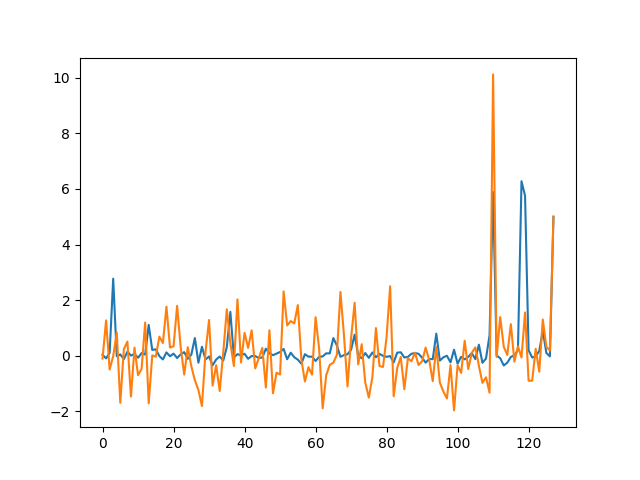

In [164]:
section=4
S=0
for i in zs[0]:
    S+=i
plt.plot(S/62)
plt.plot(zs[0][7])
# plt.plot(zs[1][section],'g')
# plt.plot(zs[2][section],'b')
plt.show()

In [146]:
from utils import myspec
tospec=np.zeros(64000)
tospec[0:63488]=(org_wf-0.5)*2
sp=myspec(tospec)


<IPython.core.display.Javascript object>


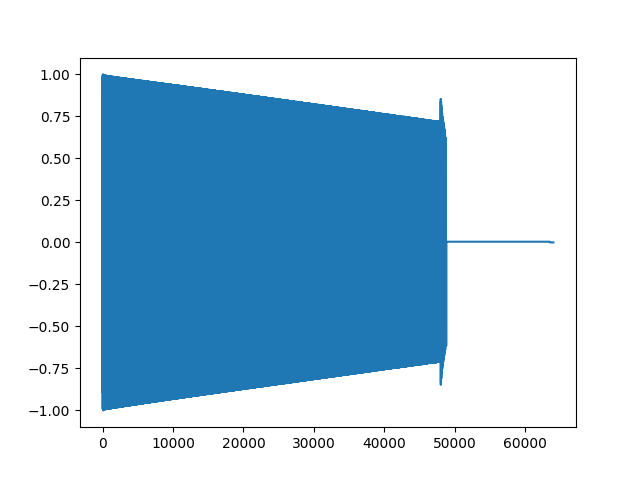

In [148]:
plt.plot(tospec)
plt.show()

<IPython.core.display.Javascript object>


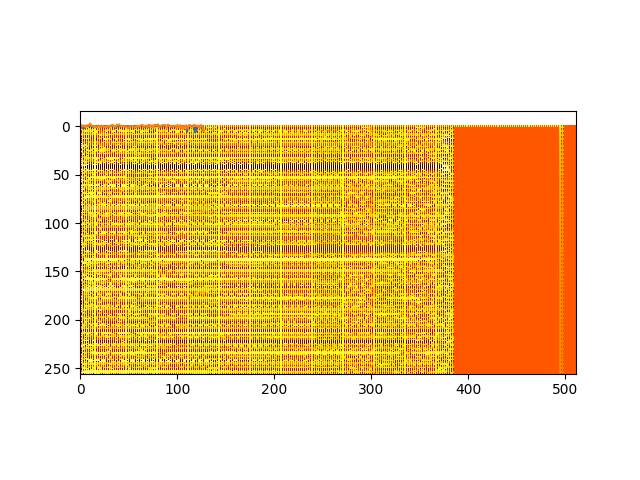

In [154]:
plt.imshow(sp[0]*20000,cmap='hot')
plt.show()

In [13]:
testz=np.sin(np.linspace(0,100*3.141,128))
# plt.plot(torch.sin(testz))
# plt.show()
testz[120]=20
testz[5]=10
testz=np.asarray([testz for i in range(62)])
print(testz.shape)
test=dec(testz)
ts=upsample(torch.sigmoid(test).detach().cpu().numpy().reshape(512*62))
test

(62, 128)


tensor([[[ 7.1246e-03, -4.8823e-03, -1.4009e-03,  ...,  7.3437e-04,
          -1.9959e-02, -1.8601e-02]],

        [[ 1.4982e+01,  1.0825e+01,  8.9315e+00,  ..., -9.4804e+00,
          -5.3727e+00,  1.3363e+00]],

        [[-5.9126e-01, -2.2456e-01,  2.9908e-01,  ..., -5.6170e-01,
          -1.4347e-01,  1.5678e-01]],

        ...,

        [[ 5.1296e-03, -6.9981e-03, -3.0246e-03,  ...,  1.6580e-03,
          -1.9295e-02, -1.7841e-02]],

        [[ 5.3690e-03, -6.6935e-03, -2.8697e-03,  ...,  9.9918e-04,
          -1.9934e-02, -1.8518e-02]],

        [[ 4.9139e-03, -7.3118e-03, -3.1331e-03,  ...,  2.6761e-03,
          -1.8285e-02, -1.6777e-02]]], device='cuda:0', grad_fn=<ViewBackward>)

<IPython.core.display.Javascript object>


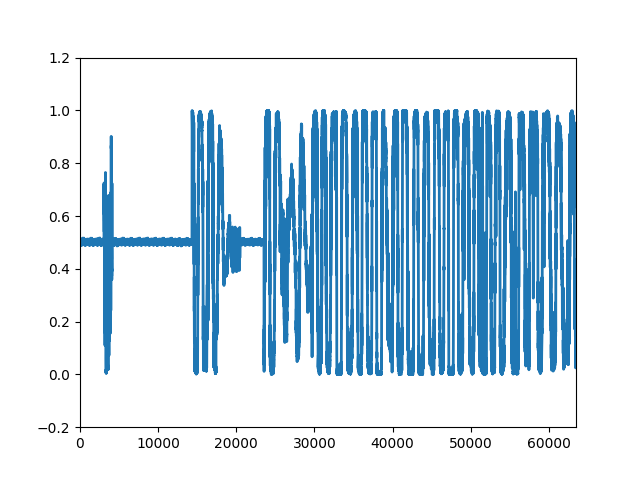

In [38]:
from matplotlib import animation, rc
from IPython.display import HTML
fig, ax = plt.subplots()

ax.set_xlim(( 0, 63488))
ax.set_ylim((-0.2, 1.2))

line, = ax.plot([], [], lw=2)


# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)



# animation function. This is called sequentially
def animate(i):
    x = np.linspace(0, 63487, 63488)
    line.set_data(x, recs[i])
    return (line,)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=200, blit=True,repeat=False)



HTML(anim.to_html5_video())



In [17]:
Audio(ts,rate=16000)

In [33]:
def freq(a):
    c=0
    for i in range(1,len(a)):
        if a[i-1]>0.5 and a[i]<0.5:
            c+=1
    return c
orgs[0].shape

(63488,)